In [1]:
import yaml
from yaml.loader import SafeLoader
from socket import gethostname
import numpy as np
from dev_interaction_util import generate_synthetic_dev_outcomes, generate_synthetic_dev_data
from ml_util import *

print(gethostname())
# Open the file and load the file
with open('config.yml') as f:
    all_yaml = yaml.load(f, Loader=SafeLoader)
    if gethostname() in all_yaml.keys():
        config = all_yaml[gethostname()]
    else:
        config = all_yaml['default']
        
print(config)



Benjamins-MacBook-Pro-2.local
{'dropbox_data_dir': '/Users/benjaminsmith/Dropbox (University of Oregon)/UO-SAN Lab/Berkman Lab/Devaluation/analysis_files/data/'}


In [2]:
dropbox_data_dir = config['dropbox_data_dir']


# Introduction
This is a pre-registered analysis for measuring moderations of the intervention.

We'll cross-validate the intervention moderations.

For this analysis, we'll try to make predictions based on some synthetic data. we'll take wave 1 data and randomly mix in changes based on our predictors, then try to model how we would predict those things. Finally, we'll make the predictions.

# Load data

In [3]:
import pandas as pd

data_by_ppt_path = dropbox_data_dir + '/data_by_ppt.csv'
data_codebook_path = dropbox_data_dir + 'data_codebook.csv'




In [4]:
data_by_ppt = pd.read_csv(data_by_ppt_path)


In [7]:
data_codebook = pd.read_csv(data_codebook_path)

In [8]:
#find out which columns in data_by_ppt are missing from the codebook
data_by_ppt.columns.difference(data_codebook['VarName'])

Index([], dtype='object')

In [9]:

#copy our outcome measures, bf_1 and FFQ_1, into a new dataframe
data_by_ppt['bf_2'] = data_by_ppt.bf_1
#need to decide what sort of FFQ we want to use
data_by_ppt['cancer_promoting_minus_preventing_FFQ_1'] = data_by_ppt.cancer_promoting_minus_preventing_FFQ
data_by_ppt['cancer_promoting_minus_preventing_FFQ_2'] = data_by_ppt.cancer_promoting_minus_preventing_FFQ

In [10]:
analysis_data  = data_by_ppt.loc[:,data_codebook.loc[data_codebook.IsSelectedPredictor,"VarName"]].copy()
outcome_measures = data_by_ppt.loc[:,data_codebook.loc[data_codebook.IsSelectedOutcomeMeasure,"VarName"]].copy()

In [11]:
na_values = pd.DataFrame(data_by_ppt.isna().sum())
na_values.columns = ['NA_Count']
na_values['prop_NA'] = na_values.NA_Count / data_by_ppt.shape[0]
data_codebook = data_codebook.merge(na_values, left_on='VarName', right_index=True)

In [12]:
data_codebook.to_csv(dropbox_data_dir + 'data_metadata.csv', index=False)

Need to count the number of valid and missing entries in each of our data predictors

## Converting data to numeric format

In [13]:
one_hot_vals = pd.get_dummies(analysis_data.birthsex_factor)
#there's only two variables here so we can convert this into a dummy variable
analysis_data.drop(columns=['birthsex_factor'], inplace=True)
one_hot_vals.columns = ['birthsex_factor_' + str(col) for col in one_hot_vals.columns]
analysis_data = analysis_data.join(one_hot_vals.iloc[:,1:])

In [14]:
analysis_data

,BSCS,EDM,BIS_11,PCS,RS,TRSQ,ACES_neglectful_parenting,ACES_abuse,ACES_sum,ACES_divorced_separated,...,zipcode_median_income_acs,household_income_per_person,SST_prop_successful_stops,SST_GRTmean,SST_SSD,SST_PostErrorSlowW1_mean,SST_mean_ssrt_0,ROC_Crave_Regulate_Minus_Look,WTP_unhealthy_minus_healthy,birthsex_factor_Male
0,2.538462,3.250,72,7.0,20.0,63.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5125,-0.312500,1
1,2.384615,1.750,89,9.0,22.0,63.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.440524,0
2,3.384615,2.500,63,9.0,18.0,57.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.500000,533.315052,284.375,0.058297,0.247061,-0.8000,-0.190476,0
3,3.076923,2.800,75,NaN,NaN,64.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.312500,498.167248,103.125,0.027730,0.446583,-0.8000,0.170363,0
4,3.307692,2.750,64,12.0,21.0,55.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.562500,626.507764,250.000,0.105660,0.369308,-1.5500,-0.494624,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,3.461538,4.000,58,18.0,17.0,54.0,0.0,1.0,3.0,1.0,...,-0.690347,1.768485,0.523438,NaN,NaN,NaN,0.357362,-0.0125,-1.008152,1
271,3.692308,3.875,54,17.0,13.0,55.0,2.0,2.0,5.0,0.0,...,-0.511475,-0.234851,0.492188,NaN,NaN,NaN,0.335849,-0.1500,-1.889247,1
272,3.461538,3.125,69,11.0,13.0,53.0,1.0,1.0,6.0,1.0,...,1.335248,0.099038,0.507812,NaN,NaN,NaN,0.273736,NaN,0.516129,1
273,2.846154,3.000,62,15.0,22.0,84.0,0.0,1.0,4.0,1.0,...,0.855379,-0.234851,0.479167,NaN,NaN,NaN,0.401098,-0.9875,-0.151210,0


# Missing data 

Apply missing data imputation to columns including cSES, ACES_sum, ses_aggregate, zipcode_median_income_acs, IMI, mcarthur social standing, based on demographic and self-report predictors.

In [15]:
# Imputing with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn import linear_model

#which columns do we want to exclude? 
# 
# Probably we can include all the columns in the codebook which aren't predictors.
# I checked, and ACES, cSES, RTFS are the only columns over 20% missing, and I'm comfortable imputing those from other values.
# Sitautions we might wnat to avoid imputing are where missingness is correlated with the predictor itself
# that's the case for IPAQ probably, but we're avoiding IPAQ altogether for now.

#analysis_data_imputed = analysis_data.loc[:,['ACES_sum','cSES']].copy()
def get_data_for_imputation(analysis_data):
    analysis_data_imputed = analysis_data.copy()
    return(analysis_data_imputed)



In [16]:
#try a few methods of imputation and compare them.
#I tried a few. the default is BayesianRidge, but i found this didn't pick up on the linear relationship between ACES and cSES
#Ridge found the linear relationship, but also does some regularization which is probably useful for accuracy

imputation_methods = {
    
    'knn_3':KNNImputer(n_neighbors=3),
    'ridge_10':IterativeImputer(estimator=linear_model.Ridge(),n_nearest_features=10,max_iter=100),
    'knn_4':KNNImputer(n_neighbors=4),
    
    'knn_6':KNNImputer(n_neighbors=6),
    'ridge':IterativeImputer(estimator=linear_model.Ridge(),max_iter=100),
    'ridge_5':IterativeImputer(estimator=linear_model.Ridge(),n_nearest_features=5,max_iter=100),
    
    'bayesianridge_3':IterativeImputer(estimator=linear_model.BayesianRidge(),max_iter=100,n_nearest_features=3)
    
}


In [18]:


# for imp_label in imputation_methods.keys():
#     analysis_data_imputed = get_data_for_imputation(analysis_data)
#     print(imp_label)
#     imp = imputation_methods[imp_label]
#     #this dataset is already filtered for columns so we don't need to filter those further.
#     analysis_data_imputed = pd.DataFrame(imp.fit_transform(analysis_data_imputed), columns=analysis_data_imputed.columns)
#     imputed_datapoint = analysis_data.isna()
#     do_aces_cses_imputation_diagnostic(analysis_data_imputed, imputed_datapoint,imp_label)
    



Based on this experiment, I'm going for Ridge regression with 10 nearest features. The values it imputes are a compromise between simply using the nearest mean, which is conservative when using these values for prediction because it doesn't introduce erroneous variance, but isn't very informative, and then using all available information, which Ridge regression with an unlimited number of features would do. It's a tough choice between this and KNN, which doesn't assume normality. Overall I'm going with KNN, because it picks up on relationships between the two variables while not generating extreme values like KNN seems to do.

In [19]:
analysis_data

,BSCS,EDM,BIS_11,PCS,RS,TRSQ,ACES_neglectful_parenting,ACES_abuse,ACES_sum,ACES_divorced_separated,...,zipcode_median_income_acs,household_income_per_person,SST_prop_successful_stops,SST_GRTmean,SST_SSD,SST_PostErrorSlowW1_mean,SST_mean_ssrt_0,ROC_Crave_Regulate_Minus_Look,WTP_unhealthy_minus_healthy,birthsex_factor_Male
0,2.538462,3.250,72,7.0,20.0,63.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5125,-0.312500,1
1,2.384615,1.750,89,9.0,22.0,63.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.440524,0
2,3.384615,2.500,63,9.0,18.0,57.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.500000,533.315052,284.375,0.058297,0.247061,-0.8000,-0.190476,0
3,3.076923,2.800,75,NaN,NaN,64.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.312500,498.167248,103.125,0.027730,0.446583,-0.8000,0.170363,0
4,3.307692,2.750,64,12.0,21.0,55.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.562500,626.507764,250.000,0.105660,0.369308,-1.5500,-0.494624,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,3.461538,4.000,58,18.0,17.0,54.0,0.0,1.0,3.0,1.0,...,-0.690347,1.768485,0.523438,NaN,NaN,NaN,0.357362,-0.0125,-1.008152,1
271,3.692308,3.875,54,17.0,13.0,55.0,2.0,2.0,5.0,0.0,...,-0.511475,-0.234851,0.492188,NaN,NaN,NaN,0.335849,-0.1500,-1.889247,1
272,3.461538,3.125,69,11.0,13.0,53.0,1.0,1.0,6.0,1.0,...,1.335248,0.099038,0.507812,NaN,NaN,NaN,0.273736,NaN,0.516129,1
273,2.846154,3.000,62,15.0,22.0,84.0,0.0,1.0,4.0,1.0,...,0.855379,-0.234851,0.479167,NaN,NaN,NaN,0.401098,-0.9875,-0.151210,0


In [20]:
imputer = IterativeImputer(estimator=linear_model.Ridge(),n_nearest_features=10,max_iter=100,random_state=0)
analysis_data_imputed = get_data_for_imputation(analysis_data)

#this dataset is already filtered for columns so we don't need to filter those further.
analysis_data_imputed = pd.DataFrame(imputer.fit_transform(analysis_data_imputed), columns=analysis_data_imputed.columns)
imputed_datapoint = analysis_data.isna()
# do_aces_cses_imputation_diagnostic(analysis_data_imputed, imputed_datapoint,'ridge_10')


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/impute/_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [21]:
analysis_data_imputed

,BSCS,EDM,BIS_11,PCS,RS,TRSQ,ACES_neglectful_parenting,ACES_abuse,ACES_sum,ACES_divorced_separated,...,zipcode_median_income_acs,household_income_per_person,SST_prop_successful_stops,SST_GRTmean,SST_SSD,SST_PostErrorSlowW1_mean,SST_mean_ssrt_0,ROC_Crave_Regulate_Minus_Look,WTP_unhealthy_minus_healthy,birthsex_factor_Male
0,2.538462,3.250,72.0,7.000000,20.000000,63.0,0.317872,0.661088,2.377413,0.524304,...,0.404760,-0.191422,0.484371,562.923974,248.939281,0.045181,0.342462,-0.512500,-0.312500,1.0
1,2.384615,1.750,89.0,9.000000,22.000000,63.0,0.410249,0.519489,2.033396,0.503125,...,0.304016,0.480210,0.553755,694.937485,381.484974,0.058525,0.263203,-0.796734,0.440524,0.0
2,3.384615,2.500,63.0,9.000000,18.000000,57.0,0.594894,1.085837,3.163201,0.577384,...,0.578832,-0.365323,0.500000,533.315052,284.375000,0.058297,0.247061,-0.800000,-0.190476,0.0
3,3.076923,2.800,75.0,11.344625,17.617698,64.0,0.262608,0.646088,1.793320,0.563715,...,0.327618,-0.068923,0.312500,498.167248,103.125000,0.027730,0.446583,-0.800000,0.170363,0.0
4,3.307692,2.750,64.0,12.000000,21.000000,55.0,0.443790,0.714933,2.528502,0.631102,...,0.230123,-0.050786,0.562500,626.507764,250.000000,0.105660,0.369308,-1.550000,-0.494624,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,3.461538,4.000,58.0,18.000000,17.000000,54.0,0.000000,1.000000,3.000000,1.000000,...,-0.690347,1.768485,0.523438,564.326545,247.685788,0.074503,0.357362,-0.012500,-1.008152,1.0
271,3.692308,3.875,54.0,17.000000,13.000000,55.0,2.000000,2.000000,5.000000,0.000000,...,-0.511475,-0.234851,0.492188,570.356523,242.446242,0.062163,0.335849,-0.150000,-1.889247,1.0
272,3.461538,3.125,69.0,11.000000,13.000000,53.0,1.000000,1.000000,6.000000,1.000000,...,1.335248,0.099038,0.507812,627.534668,330.803985,0.074095,0.273736,-0.877697,0.516129,1.0
273,2.846154,3.000,62.0,15.000000,22.000000,84.0,0.000000,1.000000,4.000000,1.000000,...,0.855379,-0.234851,0.479167,498.265901,160.923504,0.056039,0.401098,-0.987500,-0.151210,0.0


# Add synthetic data

## synthetic condition mediator

In [22]:
#set np random seed
np.random.seed(3161527)

In [23]:
group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])



## synthetic outcome variables

Which variables will we test to predict? We need to select variables from the following groups:

 - self-report variables
 - demographic variables we'll test
 - summaries of neural activities from each of WTP, SST, and ROC
 - summaries of behavioral data from each of WTP, SST, and ROC




In [24]:
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

## add synthetic primary and interaction effects

In [25]:
import pandas as pd
synthetic_data = generate_synthetic_dev_data(analysis_data_imputed, group_assignments,outcome_measures)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

# Further preprocessing

These steps are performed on the data regardless of whether we are using synthetic data or real data.

## Set up outcome measures and group assignment one-hot





In [26]:
outcome_measures = calculate_outcome_changes(outcome_measures)

In [27]:
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

In [28]:
outcome_measures.loc[:,['bf_1','bf_2','d_bf']]

,bf_1,bf_2,d_bf
0,33.0,121.373628,88.373628
1,NaN,NaN,NaN
2,39.8,58.983743,19.183743
3,40.8,40.022751,-0.777249
4,47.6,-33.046255,-80.646255
...,...,...,...
270,29.9,31.240484,1.340484
271,33.1,28.992403,-4.107597
272,27.4,51.350718,23.950718
273,42.1,64.553479,22.453479


## Set up data

In [29]:

predictor_data = analysis_data_imputed
predictor_data_columns = predictor_data.columns
predictor_data_array = np.array(predictor_data)
predictor_data = pd.concat([predictor_data,group_assignment_onehots],axis=1)
for group_name in group_assignment_onehots.columns:

    #do a matrix multiplication of the group assignment onehot with the analysis data
    #repeat the group assignment onehot for each column in the analysis data
    
    interaction_array = predictor_data_array*np.array(group_assignment_onehots[group_name],ndmin=2).T
    interaction_df = pd.DataFrame(interaction_array, columns= [(c + '*'+group_name) for c in predictor_data_columns])
    print(interaction_df.shape)
    #then add the result to the analysis data
    predictor_data = pd.concat([predictor_data,interaction_df],axis=1)

    



(275, 76)
(275, 76)


In [30]:
#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]


In [31]:
outcome_measures_nona['d_bf']

0      88.373628
2      19.183743
3      -0.777249
4     -80.646255
6       0.827321
         ...    
270     1.340484
271    -4.107597
272    23.950718
273    22.453479
274    23.806888
Name: d_bf, Length: 270, dtype: float64

# Run a basic regression with interactions to ensure we can detect effects

Here we want to know: which variables are correlated with the outcome measures? A naive way is to use ridge regression to predict the outcome measures from the predictors, with every predictor crossed with a one-hot of the group assignment. 

To do this, unlike in R where we'd write out an equation and let the system take care of it, here, I'll build the interactions manually.

Now do ridge regression to hopefully identify any predictors of outcome measures.

In [32]:
import statsmodels.api as sm

predictor_data_nona = sm.add_constant(predictor_data_nona)
model = sm.OLS(outcome_measures_nona['d_bf'], predictor_data_nona.loc[:,['const','ni','san','BSCS','EDM','BSCS*ni','BSCS*san','EDM*ni','EDM*san']]).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   d_bf   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.326
Date:                Tue, 04 Apr 2023   Prob (F-statistic):            0.00122
Time:                        15:26:32   Log-Likelihood:                -1433.3
No. Observations:                 270   AIC:                             2885.
Df Residuals:                     261   BIC:                             2917.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7621     33.215      0.053      0.958     -63.641      67.165
ni          -100.3524     47.064     -2.132      0.034    -193.025      -7.680
san          -20.2126     48.266     -0.419      0.676    -115.252      74.827
BSCS          -1.3075      9.939     -0.132      0.895     -20.879      18.263
EDM            0.6650      7.509      0.089      0.930     -14.122      15.452
BSCS*ni       22.3347     14.746      1.515      0.131      -6.702      51.371
BSCS*san     -24.5239     15.266     -1.606      0.109     -54.583       5.536
EDM*ni         8.6681     10.806      0.802      0.423     -12.609      29.945
EDM*san       28.2973     10.734      2.636      0.009       7.162      49.433
==============================================================================
Omnibus:                       31.657   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.734
Skew:                          -0.284   Prob(JB):                     1.01e-31
Kurtosis:                       6.516   Cond. No.                         115.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
import statsmodels.api as sm

predictor_data_nona = sm.add_constant(predictor_data_nona)
model = sm.OLS(outcome_measures_nona['d_bf'], predictor_data_nona).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   d_bf   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     208.4
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           6.38e-38
Time:                        14:47:10   Log-Likelihood:                -485.90
No. Observations:                 270   AIC:                             1434.
Df Residuals:                      39   BIC:                             2265.
Df Model:                         230                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                              -30.0280     25.767     -1.165      0.251     -82.146      22.090
BSCS                                                -2.3243      3.470     -0.670      0.507      -9.344       4.695
EDM                                                 -2.3868      2.461     -0.970      0.338      -7.364       2.591
BIS_11                                               0.1871      0.182      1.026      0.311      -0.182       0.556
PCS                                                 -0.3929      0.413     -0.952      0.347      -1.228       0.442
RS                                                  -0.1684      0.242     -0.697      0.490      -0.657       0.320
TRSQ                                                 0.0532      0.130      0.407      0.686      -0.211       0.317
ACES_neglectful_parenting                          -79.5500    197.870     -0.402      0.690    -479.781     320.681
ACES_abuse                                         -76.1594    198.014     -0.385      0.703    -476.680     324.361
ACES_sum                                            76.7746    198.057      0.388      0.700    -323.835     477.384
ACES_divorced_separated                            -74.3117    198.077     -0.375      0.710    -474.959     326.336
ACES_household_dysfunction                         -76.1972    198.459     -0.384      0.703    -477.618     325.224
BFI_agreeableness                                    0.1145      0.248      0.461      0.647      -0.388       0.617
BFI_conscientiousness                                0.6372      0.329      1.937      0.060      -0.028       1.303
BFI_extraversion                                    -0.4868      0.224     -2.171      0.036      -0.940      -0.033
BFI_neuroticism                                      0.2702      0.256      1.056      0.298      -0.248       0.788
BFI_openness                                        -0.0380      0.223     -0.171      0.865      -0.488       0.412
DEMO_mcarthur_social_standing                        0.0132      0.455      0.029      0.977      -0.907       0.934
IMI_effort_importance                                2.0814      1.759      1.183      0.244      -1.476       5.639
IMI_value_usefulness                                -1.3005      2.167     -0.600      0.552      -5.683       3.082
IMI_interest_enjoyment                               1.9611      1.225      1.600      0.118      -0.517       4.440
IMI_perceived_choice                                 0.4931      1.248      0.395      0.695      -2.031       3.017
IMI_perceived_competence                             0.9202      2.008      0.458      0.649      -3.142       4.982
NCS_get_job_done                         

In [33]:
#create a ridge regression
primary_regression = linear_model.Ridge(fit_intercept=True, alpha=1.0)

#fit the model
model_fit = primary_regression.fit(predictor_data_nona,outcome_measures_nona['d_bf'])

In [34]:
#view the coefficients
ridge_results = pd.DataFrame({
    'predictor': predictor_data_nona.columns,
    'coef': model_fit.coef_
    #'std_err': np.sqrt(np.diag(model_fit.coef_cov_)),
    #'pval': 2*(1-stats.t.cdf(np.abs(model_fit.coef_/np.sqrt(np.diag(model_fit.coef_cov_))),df=predictor_data_nona.shape[0]-predictor_data_nona.shape[1]))
})

ridge_results['coef_abs'] = np.abs(ridge_results.coef)
ridge_results = ridge_results.sort_values('coef_abs',ascending=False)

In [35]:
ridge_results

,predictor,coef,coef_abs
176,IMI_perceived_competence*san,-38.319246,38.319246
199,RMQ_lie*san,32.328790,32.328790
221,zipcode_median_income_acs*san,21.519625,21.519625
164,ACES_divorced_separated*san,-20.561807,20.561807
200,RMQ_assessment*san,-17.940740,17.940740
...,...,...,...
71,SST_SSD,0.026923,0.026923
224,SST_GRTmean*san,-0.024063,0.024063
16,BFI_openness,0.022933,0.022933
214,SRHI_healthy_minus_unhealthy*san,0.013583,0.013583


## Running models with GridSearchCV

In [36]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [45]:
alpha_10pow_lower = 6
alpha_10pow_upper = -1
alpha_increments=1
alpha_range = np.power(10,np.linspace(-alpha_10pow_lower,alpha_10pow_upper,(alpha_10pow_lower+alpha_10pow_upper)*alpha_increments+1))
# elasticnet_parameters = {
#     'alpha':alpha_range,
#     'l1_ratio': [0.1,0.3,0.5,0.9,0.99],#np.linspace(0.1,0.9,4+1),
#     'max_iter': [10000]
#     }
# print(elasticnet_parameters)
# elasticnet_model = linear_model.ElasticNet()



# elasticnet_grid_search_cv = GridSearchCV(estimator=get_estimator_with_preprocessing(elasticnet_model), param_grid = get_param_grid_with_preprocessing(elasticnet_parameters), cv=10,scoring='neg_mean_absolute_error')
# elasticnet_grid_search_cv.fit(predictor_data_nona,outcome_measures_nona['d_bf'])


In [46]:

ridge_parameters = {'alpha':alpha_range}
ridge_model = linear_model.Ridge()
print(ridge_parameters)
ridge_grid_search_cv = GridSearchCV(estimator=get_estimator_with_preprocessing(ridge_model), param_grid = get_param_grid_with_preprocessing(ridge_parameters), cv=10,scoring='neg_mean_absolute_error')
ridge_grid_search_cv.fit(predictor_data_nona,outcome_measures_nona['d_bf'])
sorted(ridge_grid_search_cv.cv_results_.keys())



{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_estimator__alpha',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'split5_test_score',
 'split6_test_score',
 'split7_test_score',
 'split8_test_score',
 'split9_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [49]:
ridge_grid_search_cv.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('estimator', Ridge(alpha=0.01))],
 'verbose': False,
 'scaler': StandardScaler(),
 'estimator': Ridge(alpha=0.01),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'estimator__alpha': 0.01,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__max_iter': None,
 'estimator__normalize': 'deprecated',
 'estimator__positive': False,
 'estimator__random_state': None,
 'estimator__solver': 'auto',
 'estimator__tol': 0.001}

In [47]:
lasso_parameters = {'alpha':alpha_range}
lasso_model = linear_model.Lasso()
print(lasso_parameters)
lasso_grid_search_cv = GridSearchCV(estimator=get_estimator_with_preprocessing(lasso_model), param_grid = get_param_grid_with_preprocessing(lasso_parameters), cv=10,scoring='neg_mean_absolute_error')
lasso_grid_search_cv.fit(predictor_data_nona,outcome_measures_nona['d_bf'])



{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.227e+03, tolerance: 6.382e+01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.208e+03, tolerance: 6.598e+01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase 

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('estimator', Lasso())]),
             param_grid={'estimator__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])},
             scoring='neg_mean_absolute_error')

In [41]:
#KNeighborsRegressor
knn_parameters = {'n_neighbors':np.unique(np.round(np.power(10,np.linspace(0,2,2*5+1)))).astype(int)}
knn_model = KNeighborsRegressor()
print(knn_parameters)
knn_grid_search_cv = GridSearchCV(estimator=get_estimator_with_preprocessing(knn_model), param_grid = get_param_grid_with_preprocessing(knn_parameters), cv=10,scoring='neg_mean_absolute_error')
knn_grid_search_cv.fit(predictor_data_nona,outcome_measures_nona['d_bf'])


{'n_neighbors': array([  1,   2,   3,   4,   6,  10,  16,  25,  40,  63, 100])}


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('estimator', KNeighborsRegressor())]),
             param_grid={'estimator__n_neighbors': array([  1,   2,   3,   4,   6,  10,  16,  25,  40,  63, 100])},
             scoring='neg_mean_absolute_error')

## Display models

In [42]:
def extract_estimator_params_from_gridsearch(param_dict):
    dict_list = [{k.replace(pipeline_estimator_name + "__",""):param_dict[k]} for k in param_dict.keys() if k.startswith(pipeline_estimator_name)]
    #convert the dict_list into a dict
    return({k:v for d in dict_list for k,v in d.items()})

In [43]:
#plot a heatmap of cv_results_ for the param alpha and l1_ratio using matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


#convert the cv_results_ to a dataframe
# elasticnet_cv_results_df = pd.DataFrame(elasticnet_grid_search_cv.cv_results_)
# estimator_params = elasticnet_cv_results_df.params.apply(lambda x: extract_estimator_params_from_gridsearch(x))
# elasticnet_cv_results_df['alpha'] = estimator_params.apply(lambda x: x['alpha'])
# elasticnet_cv_results_df['l1_ratio'] = estimator_params.apply(lambda x: x['l1_ratio'])
# elasticnet_cv_results_df['mean_test_score'] = elasticnet_cv_results_df.mean_test_score*-1

# #plot the heatmap
# plt.figure(figsize=(10,10))
# sns.heatmap(elasticnet_cv_results_df.pivot(index='alpha',columns='l1_ratio',values='mean_test_score'),annot=True,fmt='.2f')
# plt.title('ElasticNet Mean Absolute Error')
# plt.xlabel('l1_ratio')
# plt.ylabel('alpha')
# plt.show()

Text(0.5, 1.0, 'KNN Mean Absolute Error')

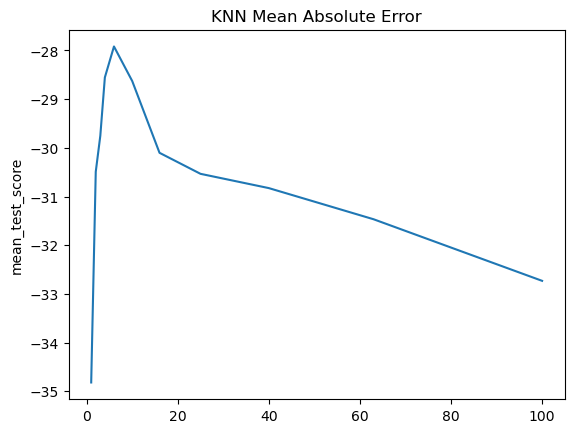

In [50]:
#graph alpha and mean_test_score
#use the log10 of alpha but label the x-axis with alpha
import matplotlib.pyplot as plt
plt.figure()
plt.plot([extract_estimator_params_from_gridsearch(p)['n_neighbors'] for p in knn_grid_search_cv.cv_results_['params']],knn_grid_search_cv.cv_results_['mean_test_score'])
plt.ylabel('mean_test_score')
plt.title('KNN Mean Absolute Error')


Text(0.5, 1.0, 'Lasso Mean Absolute Error')

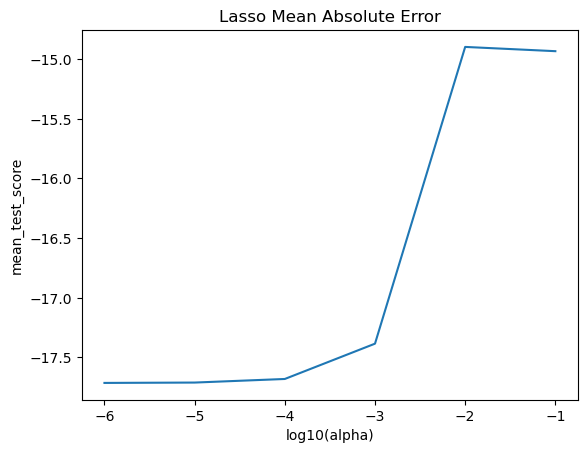

In [42]:


#graph alpha and mean_test_score
#use the log10 of alpha but label the x-axis with alpha
import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.log10([extract_estimator_params_from_gridsearch(p)['alpha'] for p in lasso_grid_search_cv.cv_results_['params']]),lasso_grid_search_cv.cv_results_['mean_test_score'])
plt.xlabel('log10(alpha)')
plt.ylabel('mean_test_score')
plt.title('Lasso Mean Absolute Error')


Text(0.5, 1.0, 'Ridge Mean Absolute Error')

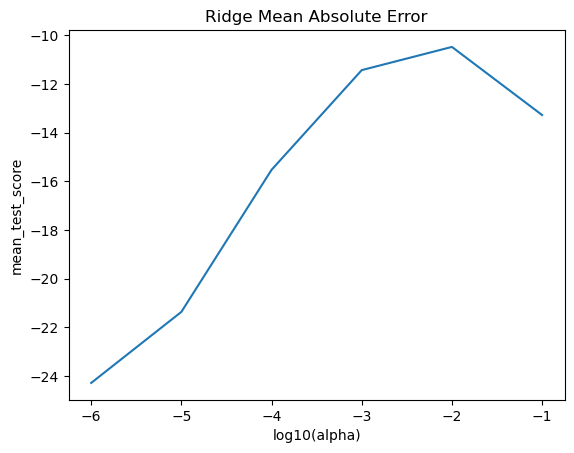

In [51]:
#graph alpha and mean_test_score
#use the log10 of alpha but label the x-axis with alpha
import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.log10([p['estimator__alpha'] for p in ridge_grid_search_cv.cv_results_['params']]),ridge_grid_search_cv.cv_results_['mean_test_score'])
plt.xlabel('log10(alpha)')
plt.ylabel('mean_test_score')
plt.title('Ridge Mean Absolute Error')


Text(0.5, 1.0, 'Ridge Mean Absolute Error')

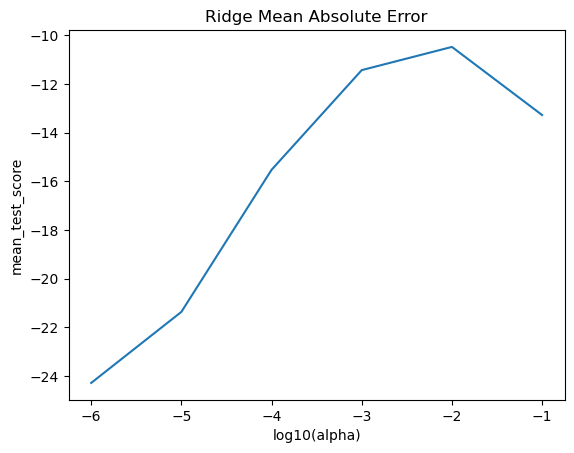

In [47]:
#graph alpha and mean_test_score
#use the log10 of alpha but label the x-axis with alpha
import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.log10([extract_estimator_params_from_gridsearch(p)['alpha'] for p in ridge_grid_search_cv.cv_results_['params']]),ridge_grid_search_cv.cv_results_['mean_test_score'])
plt.xlabel('log10(alpha)')
plt.ylabel('mean_test_score')
plt.title('Ridge Mean Absolute Error')


## pick the best model

In [ ]:
all_cv_results = [ridge_grid_search_cv, lasso_grid_search_cv, elasticnet_grid_search_cv, knn_grid_search_cv]

#create a dataframe with the best parameters, best mean_test_score, and name of the model

best_params_df = pd.DataFrame({
    'model': [cv_result.estimator for cv_result in all_cv_results],
    'model_name': [cv_result.estimator.__class__.__name__ for cv_result in all_cv_results],
    'best_params': [extract_estimator_params_from_gridsearch(cv_result.best_params_) for cv_result in all_cv_results],
    'best_score': [cv_result.best_score_ for cv_result in all_cv_results],
    'best_raw_params' : [cv_result.best_params_ for cv_result in all_cv_results]
    })




In [ ]:
from sklearn.base import clone

best_params_df = best_params_df.sort_values('best_score',ascending=False).reset_index(drop=True)

best_model = clone(best_params_df['model'][0])
best_model_params = best_params_df['best_raw_params'][0]
best_model.set_params(**best_model_params)

To do next:

 - normalize the dataset, using a pipeline so that normalizing is only done on the training set, with the same transformation then done on the test set. 
   - DONE
 - after that, we'll have a reasonable pipeline for model selection, but we then need to embed that in a nested CV for estimating generalization.
 - Need to deal with the 

Ridge regression seems to perform best so far, on this dataset. If the Ridge regression performs best on the actual dataset, we would potentially choose it. But we might want to rule it out from the start because it doesn't entirely eliminate variables that aren't predictive. Note that the actual, final dataset might be quite different and there's no real reason to think that it will respond in the same wya. In particular, it might choose an entirely different model. we should also ensure the grid-search has a range of params that is wider than the range we specialized on here.

# optimizing ridge regression using nested cross-validation

In [ ]:
# split the sample into 10 folds using sklearn
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold



n_folds = 10
#make sure there are an equal number of samples from each class in each fold
kf = KFold(n_splits=n_folds, shuffle=True)



# for each fold, run a grid search to find the best parameters
# then use hte best parameters to fit the model and predict the test set
# then calculate the mean absolute error for the test set
# repeat for each fold
# then average the mean absolute error across all folds
# then pick the best fitting parameter set to generate a final model
# that final model will be somewhat overfit, but we can perhaps use a control to make sure it's not excessively overfit




Things I need to sort out here:

1. Is the pattern of GridSearchCV followed by cross_val_score enough? See https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
2. How do we do the nested cross-validation, with the constraint that we use the same sets of groups for the inner and outer CV?

It seems that whether we do GridSearchCV followed by cross_val_score, or follow the manual pattern I was planning, we need either a custom CV or a custom iterable. Perhaps we should try a custom CV class, wrapping StratifiedKFold, which stratifies on a third variable passed to the constructor.


### IndependentVarStratifiedKFold function

In [ ]:
from sklearn.utils.validation import column_or_1d
from sklearn.utils import check_random_state
from sklearn.utils.multiclass import type_of_target
from sklearn.model_selection import StratifiedKFold
import numpy as np
import warnings

class IndependentVarStratifiedKFold(StratifiedKFold):
    def __init__(self, independent_vars, n_splits=5, shuffle=False, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
        self.independent_vars = independent_vars

    # def _iter_test_masks(self, X, y=None, groups=None):
    #     test_folds = self._make_test_folds(X, y)
    #     for i in range(self.n_splits):
    #         yield test_folds == i

    def _iter_test_indices(self, X, y, groups):
        unique_independent_vars, counts = np.unique(self.independent_vars, return_counts=True)
        for test_index in super()._iter_test_indices(X, self.independent_vars, groups):
            test_independent_vars = self.independent_vars[test_index]
            _, test_counts = np.unique(test_independent_vars, return_counts=True)
            if np.all(counts >= test_counts):
                yield test_index

    def _make_test_folds(self, X, y=None):
        rng = check_random_state(self.random_state)
        g = np.asarray(self.independent_vars)
        type_of_target_g = type_of_target(g)
        allowed_target_types = ("binary", "multiclass")
        if type_of_target_g not in allowed_target_types:
            warnings.warn(
                "Supported target types are: {}. Got {!r} instead.".format(
                    allowed_target_types, type_of_target_g
                )
            )

        g = column_or_1d(g)

        _, g_idx, g_inv = np.unique(g, return_index=True, return_inverse=True)
        # y_inv encodes y according to lexicographic order. We invert y_idx to
        # map the classes so that they are encoded by order of appearance:
        # 0 represents the first label appearing in y, 1 the second, etc.
        _, class_perm = np.unique(g_idx, return_inverse=True)
        g_encoded = class_perm[g_inv]

        n_classes = len(g_idx)
        g_counts = np.bincount(g_encoded)
        min_groups = np.min(g_counts)
        if np.all(self.n_splits > g_counts):
            raise ValueError(
                "n_splits=%d cannot be greater than the"
                " number of members in each class." % (self.n_splits)
            )
        if self.n_splits > min_groups:
            warnings.warn(
                "The least populated class in y has only %d"
                " members, which is less than n_splits=%d."
                % (min_groups, self.n_splits),
                UserWarning,
            )

        # Determine the optimal number of samples from each class in each fold,
        # using round robin over the sorted y. (This can be done direct from
        # counts, but that code is unreadable.)
        g_order = np.sort(g_encoded)
        allocation = np.asarray(
            [
                np.bincount(g_order[i :: self.n_splits], minlength=n_classes)
                for i in range(self.n_splits)
            ]
        )

        # To maintain the data order dependencies as best as possible within
        # the stratification constraint, we assign samples from each class in
        # blocks (and then mess that up when shuffle=True).
        test_folds = np.empty(len(g), dtype="i")
        for k in range(n_classes):
            # since the kth column of allocation stores the number of samples
            # of class k in each test set, this generates blocks of fold
            # indices corresponding to the allocation for class k.
            folds_for_class = np.arange(self.n_splits).repeat(allocation[:, k])
            if self.shuffle:
                rng.shuffle(folds_for_class)
            test_folds[g_encoded == k] = folds_for_class
        return test_folds


# create a stratified k-fold object
# the independent variable is the 'group' column
# this will ensure that each fold has an equal number of samples from each group
# this is important because we want to make sure that each fold has an equal number of samples from each class

cv = IndependentVarStratifiedKFold(independent_vars=group_assignments_nona, n_splits=3, shuffle=True, random_state=0)

# now do cv.split and print the items in each fold
for train_ik, test_i in cv.split(predictor_data_nona, group_assignments_nona):
    print("TRAIN:", np.array(train_ik), "TEST:", np.array(test_i))
    #test to see if this works on the group assignments
    print("train:")
    print(pd.Series(group_assignments_nona[train_ik]).value_counts())
    print("test:")
    print(pd.Series(group_assignments_nona[test_i]).value_counts())

    

## Design the splitting

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# create a stratified k-fold object
# the independent variable is the 'group' column
# this will ensure that each fold has an equal number of samples from each group
# this is important because we want to make sure that each fold has an equal number of samples from each class
outer_splits = 10
inner_splits = outer_splits - 1

outer_cv = IndependentVarStratifiedKFold(independent_vars=group_assignments_nona, n_splits=outer_splits, shuffle=True, random_state=3211050)
#hold up. how does cross_val_score manage with an outer and inner CV that are defined at the same time?
#maybe it doesn't matter.


# now do cv.split and print the items in each fold
for i, (train_i, test_i) in enumerate(outer_cv.split(predictor_data_nona, outcome_measures_nona['d_bf'])):
    print("outer split" + str(i))
    #print(str(train_ik) + ", " + str(test_i))

    #the problem with this design is we STILL, if we want to pass this to a nested CV, have to split *further* in order to hold out one component of data for validation
    #if we use the GridSearchCV followed by cross_val_score pattern, it *might* work???



    #print("TRAIN:", np.array(train_i), "TEST:", np.array(test_i))
    #test to see if this works on the group assignments
    print("train:"+ str(dict(pd.Series(group_assignments_nona[train_i]).value_counts())) + ", " + 
          "test:" + 
        str(dict(pd.Series(group_assignments_nona[test_i]).value_counts()))
    )

    

    train_i_X = predictor_data_nona.iloc[train_i]
    train_i_y = outcome_measures_nona['d_bf'].iloc[train_i]
    train_i_group_assignments = group_assignments_nona[train_i]

    inner_cv = IndependentVarStratifiedKFold(independent_vars=train_i_group_assignments, n_splits=inner_splits, shuffle=True, random_state=3211050)
    for j, (train_j, test_j) in enumerate(inner_cv.split(train_i_X, train_i_y)):
        print("inner split " + str(j))
        #print("TRAIN:", np.array(train_i[train_j]), "TEST:", np.array(train_i[test_j]))
        print("train:" + str(dict(pd.Series(train_i_group_assignments[train_j]).value_counts())) + "; "
              "test:" + str(dict(pd.Series(train_i_group_assignments[test_j]).value_counts())))
    
    #gridsearch = GridSearchCV(estimator=Ridge(), param_grid={'alpha':[0.1,0.5,0.9]}, cv=inner_cv)

    

## Try GridSearchCV with cross_val_score

In [ ]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# inner_cv = IndependentVarStratifiedKFold(independent_vars=group_assignments_nona, n_splits=4, shuffle=True, random_state=0)
# outer_cv = IndependentVarStratifiedKFold(independent_vars=group_assignments_nona, n_splits=4, shuffle=True, random_state=0)
inner_cv = KFold(n_splits=4, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=0)


gridsearch = GridSearchCV(estimator=Ridge(), param_grid={'alpha':[0.1,0.5,0.9]}, cv=inner_cv)
nested_score = cross_val_score(gridsearch, X=predictor_data_nona, y=outcome_measures_nona['d_bf'], cv=outer_cv)
nested_scores = nested_score.mean()



## Building a function to do CV

In [ ]:
import numpy as np
#import clone
from sklearn.base import clone

def do_hyperparameter_selection_on_fold(X, y,cv):
    alpha_10pow_lower = 6
    alpha_10pow_upper = -1
    alpha_increments=1
    alpha_range = np.power(10,np.linspace(-alpha_10pow_lower,alpha_10pow_upper,(alpha_10pow_lower+alpha_10pow_upper)*alpha_increments+1))

    ############
    #RIDGE
    ridge_parameters = {'alpha':alpha_range}
    ridge_model = linear_model.Ridge()
    print(ridge_parameters)
    #do a gridsearch, using the same folds as the outer loop
    ridge_grid_search_cv = GridSearchCV(estimator=get_estimator_with_preprocessing(ridge_model), param_grid = get_param_grid_with_preprocessing(ridge_parameters), cv=cv,scoring='neg_mean_absolute_error')
    ridge_grid_search_cv.fit(X,y)

    ############
    #LASSO
    lasso_parameters = {'alpha':alpha_range}
    lasso_model = linear_model.Lasso()
    print(lasso_parameters)
    lasso_grid_search_cv = GridSearchCV(estimator=get_estimator_with_preprocessing(lasso_model), param_grid = get_param_grid_with_preprocessing(lasso_parameters), cv=cv,scoring='neg_mean_absolute_error')
    lasso_grid_search_cv.fit(X,y)



    all_cv_results = [ridge_grid_search_cv, lasso_grid_search_cv]

    #create a dataframe with the best parameters, best mean_test_score, and name of the model

    best_params_df = pd.DataFrame({
        'model': [cv_result.estimator for cv_result in all_cv_results],
        'model_name': [cv_result.estimator.__class__.__name__ for cv_result in all_cv_results],
        'best_params': [extract_estimator_params_from_gridsearch(cv_result.best_params_) for cv_result in all_cv_results],
        'best_score': [cv_result.best_score_ for cv_result in all_cv_results],
        'best_raw_params' : [cv_result.best_params_ for cv_result in all_cv_results]
        })
    
    best_params_df = best_params_df.sort_values('best_score',ascending=False).reset_index(drop=True)

    best_model = clone(best_params_df['model'][0])
    best_model_params = best_params_df['best_raw_params'][0]
    best_model.set_params(**best_model_params)

    return {
        'best_model': best_model,
        'best_params_df':best_params_df,
        'raw_cv_results':all_cv_results
    }



    

## Try out CV with simple gridsearch

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

outer_splits = 4
inner_splits = outer_splits - 1

outer_cv = IndependentVarStratifiedKFold(independent_vars=group_assignments_nona, n_splits=outer_splits, shuffle=True, random_state=3211050)
#hold up. how does cross_val_score manage with an outer and inner CV that are defined at the same time?
#maybe it doesn't matter.

scores = []

best_models = []
best_params_df_list = []
raw_cv_results_list = []

# now do cv.split and print the items in each fold
for i, (train_i, test_i) in enumerate(outer_cv.split(predictor_data_nona, outcome_measures_nona['d_bf'])):
    print("outer split" + str(i))

    #test to see if this works on the group assignments
    print("train:"+ str(dict(pd.Series(group_assignments_nona[train_i]).value_counts())) + ", " + 
          "test:" + 
        str(dict(pd.Series(group_assignments_nona[test_i]).value_counts()))
    )

    train_i_X = predictor_data_nona.iloc[train_i]
    train_i_y = outcome_measures_nona['d_bf'].iloc[train_i]
    train_i_group_assignments = group_assignments_nona[train_i]
    print(train_i_y)

    test_i_X = predictor_data_nona.iloc[test_i]
    test_i_y = outcome_measures_nona['d_bf'].iloc[test_i]
    print(test_i_y)

    inner_cv = IndependentVarStratifiedKFold(independent_vars=train_i_group_assignments, n_splits=inner_splits, shuffle=True, random_state=3211050)

    selection_info = do_hyperparameter_selection_on_fold(train_i_X, train_i_y,cv = inner_cv)
    best_model_i = selection_info['best_model']
    best_params_i = selection_info['best_params_df']
    best_models.append(best_model_i)
    best_params_df_list.append(best_params_i)
    raw_cv_results_list.append(selection_info['raw_cv_results'])

    best_model_i.fit(train_i_X, train_i_y)
    score_r2_i = best_model_i.score(test_i_X, test_i_y)

    scores.append(score_r2_i)

    


    #now fit the model on the training data
    #gridsearch.fit(train_i_X, train_i_y)

    #model_with_hypers = gridsearch.cv_results_.keys()
    #print(model_with_hypers)

    #score = model_with_hypers.score(test_i_X, test_i_y)
    #scores.append(score)


    #best_score = gridsearch.score(train_i_X.iloc[test_j], train_i_y.iloc[test_j])

    

In [ ]:
print(scores)
overall_score = np.mean(scores)

In [ ]:
warnings.warn("Need to test how this runs with different numbers of variables because I'm getting wildly varying performance scores.")

In [ ]:
overall_score

Now we need to pick the best model, including model parameters. Two ways to do it; one is to follow the way its done in CV; the otehr is to do it like this:

 - We use each fold to 'vote' for a model, including the particular parameters used.
 - Possibly it will be a tie in that there will be two or more models with specific parameters that are chosen as best; possibly every single fold will have selected a slightly different set of parameters. In that case, if two or more models are 'first equal', eliminate the others, then select the model that got the highest test performance.

Now if we followed how it's one in CV, perhaps we just run GridSearchCV one more time, across the entire dataset, to select model parameters. hmm. That is _definitely_ going to over-fit, but I'm not sure it will be biased to choose excessive precision, because we'll still be doing train/test analysis.


Alternatively we could just use the data that GridSearchCV has _already generated_ to select the best model, by (I assume) adding up the performance for each model over the whole GridSearch and picking the best one. That would involve extracting performance for _every single model_ across ALL GridSearches and then combining them.

In [ ]:
cv_results_list = []
for i, raw_result_fold_i in enumerate(raw_cv_results_list):
    for gsm in raw_cv_results_list[i]:
        gsm_j_cv_results_df = pd.DataFrame(gsm.cv_results_)
        gsm_j_cv_results_df['fold'] = i
        gsm_j_cv_results_df['model_description'] = str(gsm.estimator.named_steps.values())
        gsm_j_cv_results_df['model'] = gsm.estimator
        
        cv_results_list.append(gsm_j_cv_results_df)

cv_results_df = pd.concat(cv_results_list)
cv_results_df['params_str'] = cv_results_df['params'].astype(str)

In [ ]:
#group by model_description and params across folds and get the mean and std of the mean and std test scores

list_model_performance = (cv_results_df
 .groupby(['model_description','params_str'])
 .agg({'mean_test_score':['mean','std'],'std_test_score':['mean','std']})
 .sort_values(('mean_test_score','mean'),ascending=False)
)

list_model_performance

And that's one way to do it! I am still concerned about overfitting.

At least we won't be picking hyper-parameters that do excessive overfitting, but we might still be over-optimizing hyper-parameters on this specific dataset. That would lead to an inflated performance estimate, but we are not using this for peformance. It would also lead to an inflated fit of the parameters to the data, but  (1) it's not clear any of the _other_ fits would be better; (2) because the hyper-parameters are taken from the cross-validation process, 

Perhaps it's better to re-run the GridSearchCV one more time on the full dataset; that would be less optimization, I think.

## Fit model

In [ ]:
overall_fits =  (cv_results_df
 .groupby(['model_description','params_str'])
 .agg({'mean_test_score':['mean','std'],'std_test_score':['mean','std']})
).reset_index()

#identify the index of best fit
best_fit_description = overall_fits[overall_fits[('mean_test_score','mean')]==overall_fits[('mean_test_score','mean')].max()]

In [ ]:
best_fit_characteristics =  cv_results_df.loc[((cv_results_df['model_description']==best_fit_description['model_description'].values[0]) & 
                   (cv_results_df['params_str']==best_fit_description['params_str'].values[0])),:].iloc[0]

In [ ]:
best_model = clone(best_fit_characteristics.model)
best_model_params = best_fit_characteristics.params
best_model.set_params(**best_model_params)


Now, estimate based on ALL the data to get a set of regressors we can report.

In [ ]:
final_fit = best_model.fit(predictor_data_nona, outcome_measures_nona['d_bf'])
final_estimator = final_fit.named_steps['estimator']

In [ ]:
#view the coefficients
final_results = pd.DataFrame({
    'predictor': predictor_data_nona.columns,
    'coef': final_estimator.coef_
    #'std_err': np.sqrt(np.diag(model_fit.coef_cov_)),
    #'pval': 2*(1-stats.t.cdf(np.abs(model_fit.coef_/np.sqrt(np.diag(model_fit.coef_cov_))),df=predictor_data_nona.shape[0]-predictor_data_nona.shape[1]))
})

final_results['coef_abs'] = np.abs(final_results.coef)
final_results = final_results.sort_values('coef_abs',ascending=False)

In [ ]:
selected_features_count = np.sum(final_estimator.coef_!=0)
print(f"Number of selected features: {selected_features_count}")

In [ ]:
final_results[0:20]